In [76]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

# Task 1

## Part 1

### 1.

#### a.

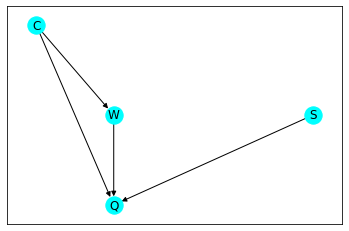

In [58]:
G = nx.DiGraph()

G.add_edges_from([
    ('C', 'Q'),
    ('W', 'Q'),
    ('S', 'Q'),
    ('C', 'W')
])

pos = graphviz_layout(G, prog='dot')
nx.draw_networkx(G, node_color='cyan', pos=pos)

#### b.

$$P(Q, W, S, C) \propto P(Q | W, S, C) \cdot P(W | C) \cdot P(S) \cdot P(C)$$

### 2.

<AxesSubplot:>

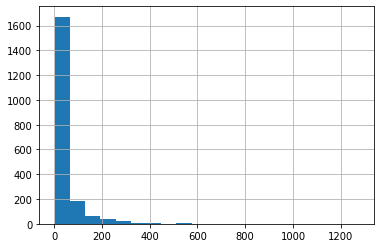

In [59]:
import pandas as pd

df_qc_train = pd.read_csv('QualityControlTraining.csv')
df_qc_train.Wait_Time.hist(bins=20)

The histogram for wait time is heavily skewed right

<AxesSubplot:>

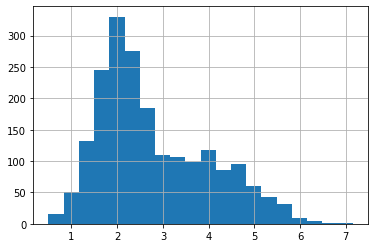

In [60]:
np.log(df_qc_train.Wait_Time).hist(bins=20)

This histogram appears to be a mixture of two gaussians, where the first is centered around 2 with small variance and the second is centered around 3.5 with larger variance.

### 3.

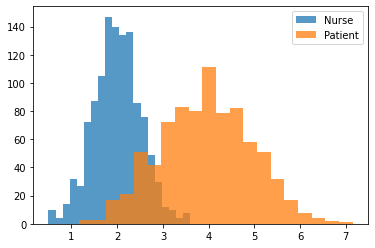

In [61]:
lg_wait_time_nurse = np.log(df_qc_train[df_qc_train.Collection_Method == 'Nurse'].Wait_Time)
lg_wait_time_patient = np.log(df_qc_train[df_qc_train.Collection_Method == 'Patient'].Wait_Time)

bins = 20
alpha = .75

plt.hist(lg_wait_time_nurse, bins=bins, alpha=alpha)
plt.hist(lg_wait_time_patient, bins=bins, alpha=alpha)
plt.legend(['Nurse', 'Patient'])

In [62]:
mean, std = lg_wait_time_nurse.mean(), lg_wait_time_nurse.std()
print(f'Nurse stats: mean = {mean:.3f}, std = {std:.3f}')

Nurse stats: mean = 1.997, std = 0.519


### 4.

#### a.

For each $C \in \{P, N\}$,
$$Q | C, W, S \sim \mathcal{N}(\mu_C(W,S), \sigma_C),$$
where
\begin{align*}
    \mu_C(w, s) &= \begin{bmatrix}1 & \log(w) & s\end{bmatrix}^\top a_C & \text{for some fixed } a_C &\in \mathbb{R}^3, \\
    \sigma_C &\in \mathbb{R} \text{ is fixed}
\end{align*}

#### b.

$$P_{\theta_P}(q_i, w_i, s_i, P) \propto P_{\theta_P}(q_i | w_i, s_i, P) \cdot P_{\theta_P}(w_i | P) \cdot P_{\theta_P}(s_i) \cdot P_{\theta_P}(P)$$

#### c.

\begin{align*}
P_{\theta_P}(q_i, w_i, s_i, P) &\propto P_{\theta_P}(q_i | w_i, s_i, P) \\
&\propto \frac{1}{\sigma_P} \exp\left( -\frac{1}{2\sigma_P^2} \left(q_i - \begin{bmatrix}1 & \log(w_i) & s_i\end{bmatrix}^\top a_P \right)^2 \right) \\
\Rightarrow \theta^*_P &= \underset{\sigma_P, a_P}{\arg\max} \; \sigma_P^{-|I_P|} \exp\left( -\frac{1}{2\sigma_P^2} \sum_{i\in I_P}   \left(q_i - \begin{bmatrix}1 & \log(w_i) & s_i\end{bmatrix}^\top a_P \right)^2 \right) \\
&= \underset{\sigma_P, a_P}{\arg\min} \; \log \sigma_P + \frac{1}{2\sigma_P^2} \sum_{i\in I_P}   \left(q_i - \begin{bmatrix}1 & \log(w_i) & s_i\end{bmatrix}^\top a_P \right)^2
\end{align*}

In [126]:
df_qc_train_patient = df_qc_train[df_qc_train.Collection_Method == 'Patient']

q = df_qc_train_patient.Quality_Score
z = np.stack([
        np.ones(len(q)), 
        np.log(df_qc_train_patient.Wait_Time), 
        df_qc_train_patient.Storage_Temperature
    ], 
    axis=1)

def f(x):
    sigma = x[0]
    a = x[1:]

    return np.log(sigma) + ((q - z@a)**2).sum() / (2*sigma**2)


minimize(f, x0=[10,1,1,1])

      fun: 4.552765997058457
 hess_inv: array([[ 1.44564491e+03, -7.53584311e+01,  6.02647597e+00,
        -5.58442410e+00],
       [-7.53584311e+01,  4.16913123e+02, -1.13325487e+01,
         3.70114186e+01],
       [ 6.02647597e+00, -1.13325487e+01,  3.71300204e+00,
         3.36086604e-01],
       [-5.58442410e+00,  3.70114186e+01,  3.36086604e-01,
         3.85316206e+00]])
      jac: array([-5.96046448e-08, -2.98023224e-07, -3.57627869e-07,  1.66893005e-06])
  message: 'Optimization terminated successfully.'
     nfev: 205
      nit: 39
     njev: 41
   status: 0
  success: True
        x: array([57.55636657, -9.09228035, -1.91580732, -2.06586948])